In [4]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import re
import requests
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [3]:
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [448]:
dataset_cancer = pd.read_csv(r"C:\Users\ferch\Desktop\Henry\Proyecto Grupal\CO2-Emissions\datasets\enfermedades\casos_cancer_pulmon_fym_NORMALIZADO.csv",sep=';')
dataset_co2 = pd.read_csv(r"C:\Users\ferch\Desktop\Henry\Proyecto Grupal\CO2-Emissions\datasets\energyco2_normalizado.csv",sep=',')

In [449]:
df_cancer = pd.DataFrame(dataset_cancer)
df_co2 = pd.DataFrame(dataset_co2)
#col = 'Unnamed: 0'
# df_cancer.drop(columns=col,inplace=True)
# df_co2.drop(columns=col,inplace=True)
df_co2.rename(columns={'co2_emision_co2':'co2'},inplace=True)

In [450]:
df_cancer = df_cancer.merge(df_co2,on=['pais','anio'])

In [451]:
df_cancer = df_cancer[df_cancer['energia_tipo']=='all_energy_types']

In [452]:
paises = ['United States', 'China', 'Russia', 'Saudi Arabia', 'Canada']
cols = ['pais','anio','casos F','Casos M','energia_produccion','co2']

In [453]:
df2 = df_cancer[cols]

In [454]:
df_cancerTOP = df2[df_cancer['pais'].isin(paises)]

In [455]:
df3 = df_cancerTOP.groupby(by='pais').sum().reset_index()

In [456]:
df3['casos'] = df3['casos F'] + df3['Casos M']

In [457]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=df3['pais'],y=df3['co2'],name='CO2'))
fig.add_trace(go.Bar(x=df3['pais'],y=df3['energia_produccion'],base='stack',name='Produccion',opacity=0.6),secondary_y=False)
fig.add_trace(go.Scatter(x=df3['pais'],y=df3['casos'],name='Casos',opacity=0.5),secondary_y=True)
fig.update_layout(go.Layout(
    barmode='overlay'
))
fig.update_layout(title='Consumo vs produccion en top paises productores energia',title_x = 0.4)
fig.show()

In [458]:
df3[['casos','co2']].corr()

,casos,co2
casos,1.000000,0.893207
co2,0.893207,1.000000


KPI 2030

In [459]:
df = df_co2[df_co2['energia_tipo']=='all_energy_types']
df = df[['pais','anio','energia_cons','co2','pbi']]

In [460]:
df = df.sort_values(by=['pais','anio']).reset_index(drop=True)

In [461]:
df['pct_chg_co2'] = df['co2'].pct_change(1)*100
df['pct_chg_cons'] = df['energia_cons'].pct_change(1)*100
df = df[df['anio']>=2010]

In [462]:
paises =['United States', 'China', 'Russia', 'Saudi Arabia', 'Canada']

In [463]:
df_top = df[df['pais'].isin(paises)]

In [464]:
fig = px.line(df_top,x='anio',y='pct_chg_co2',color='pais')
fig.update_layout(title="Porcentaje de cambio en emisiones de CO2, TOP5 paises emisores")
fig.show()

In [465]:
df_kpi_2030 = df.groupby(by=['pais','anio']).sum()
df_kpi_2030 = df_kpi_2030.reset_index()
kpi = df_kpi_2030.loc[df_kpi_2030['anio']==2019,['pais','pct_chg_co2']]
kpi.sort_values(by='pct_chg_co2').head(15)

,pais,pct_chg_co2
1399,Mozambique,-27.467412
1229,Macau,-18.292683
759,Gabon,-15.681234
189,Belize,-14.705882
2059,Tonga,-11.764706
599,Equatorial Guinea,-11.553030
1819,Seychelles,-11.538462
19,Albania,-10.044643
1239,Madagascar,-8.378378
2289,Yemen,-8.296460


In [466]:
top_emisores=['United States', 'China', 'Russia', 'Saudi Arabia', 'Canada']

In [467]:
anios = [2010,2019]
df19 = df[df['anio'].isin(anios)][['pais','pbi','anio','co2']]
df19['pct_chg_co2'] = df19['co2'].pct_change(1)*100
df19 = df19[df19['anio']==2019]
df19['cumplimiento']=(df19['pct_chg_co2']+45)/-45*100

In [468]:
df19

,pais,pbi,anio,co2,pct_chg_co2,cumplimiento
39,Afghanistan,79.45,2019,9.39,50.722311,-212.716248
79,Albania,38.27,2019,4.03,33.443709,-174.319352
119,Algeria,509.07,2019,145.99,46.900785,-204.223966
159,American Samoa,NaN,2019,0.36,-40.000000,-11.111111
199,Angola,193.83,2019,17.64,42.834008,-195.186685
...,...,...,...,...,...,...
9079,Western Sahara,NaN,2019,0.26,-13.333333,-70.370370
9119,World,127690.25,2019,35584.93,16.207718,-136.017152
9159,Yemen,53.08,2019,8.29,-60.429594,34.287987
9199,Zambia,247.18,2019,7.10,200.847458,-546.327684


In [469]:
df19.query("pais != 'World'").sort_values(by='co2',ascending=False).head(5)

,pais,pbi,anio,co2,pct_chg_co2,cumplimiento
1639,China,23128.34,2019,10608.60,29.307886,-165.128636
8799,United States,19925.43,2019,5277.19,-2.340451,-94.798998
3959,India,9310.29,2019,2308.33,49.256733,-209.459406
6799,Russia,3770.42,2019,1798.24,19.437563,-143.194584
4279,Japan,5359.05,2019,1140.95,-0.343267,-99.237184


In [470]:
top_emision = df19.query("pais != 'World'").sort_values(by='co2',ascending=False).head(5)
top_reduccion = df19.sort_values(by='pct_chg_co2').head(5)
df_pbi = pd.concat([top_emision,top_reduccion])
df_pbi.dropna(subset='pbi',inplace=True)

In [471]:
df_pbi['cumplimiento'] = df_pbi['cumplimiento'].round(2)

In [472]:
df_pbi = df_pbi.sort_values(by='pbi',ascending=False)

In [473]:
title = f"Relacion PBI - cumplimiento de -45% CO2 entre TOP5 emision y TOP5 paises cumplimiento de meta (2019)"

In [474]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=df_pbi['pais'],y=df_pbi['pbi'],name='PBI'))
fig.add_trace(go.Scatter(x=df_pbi['pais'],y=df_pbi['cumplimiento'],name='Cumplimiento',mode='markers', marker_color=df_pbi['cumplimiento'],),secondary_y=True)
fig.update_layout(title=title)
fig.show()

In [475]:
data = pd.read_csv(r"C:\Users\ferch\Desktop\Henry\Proyecto Grupal\CO2-Emissions\datasets\NORMALIZADO_central_electrica.csv",sep=';')
df_pp = pd.DataFrame(data)

In [476]:
df_pp.drop(columns=col,inplace=True)

NameError: name 'col' is not defined

In [ ]:
df_pp

,codigo_iso,pais,nombre,capacidad_MW,latitud,longitud,energia_primaria,otra_energia1,año_apertura,año_capacidad_reportada,anio,GWh_x_anio
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,33.0,32.3220,65.1190,Hydro,NaN,NaN,2017.0,2013,NaN
1,AFG,Afghanistan,Kandahar DOG,10.0,31.6700,65.7950,Solar,NaN,NaN,NaN,2013,NaN
2,AFG,Afghanistan,Kandahar JOL,10.0,31.6230,65.7920,Solar,NaN,NaN,NaN,2013,NaN
3,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,66.0,34.5560,69.4787,Hydro,NaN,NaN,2017.0,2013,NaN
4,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,100.0,34.6410,69.7170,Hydro,NaN,NaN,2017.0,2013,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
244547,ZMB,Zambia,Ndola,50.0,-12.9667,28.6333,Oil,NaN,NaN,NaN,2019,NaN
244548,ZMB,Zambia,Nkana,20.0,-12.8167,28.2000,Oil,NaN,NaN,NaN,2019,NaN
244549,ZMB,Zambia,Victoria Falls,108.0,-17.9167,25.8500,Hydro,NaN,NaN,NaN,2019,NaN
244550,ZWE,Zimbabwe,Hwange Coal Power Plant Zimbabwe,920.0,-18.3835,26.4700,Coal,NaN,NaN,2017.0,2019,NaN


In [ ]:
contaminantes = ['Gas','Oil','Coal','Petcoke','Waste','Biomass']

In [ ]:
df_pp =df_pp[df_pp['energia_primaria'].isin(contaminantes)]

In [ ]:
df_pp['text'] = df_pp['nombre'] + ',' + df_pp['pais'] + ', ' + df_pp['energia_primaria'] + '' + 'Capacidad: ' + df_pp['capacidad_MW'].astype(str)

fig = go.Figure(data=go.Scattergeo(
        lon = df_pp['longitud'],
        lat = df_pp['latitud'],
        text = df_pp['text'],
        mode = 'markers',
        marker_color = df_pp['capacidad_MW'], 
        opacity=0.8
        ))

fig.update_layout(
        title = 'Plantas productoras de energia contaminantes',
        title_x = 0.5,
        geo_scope='world',
    )
fig.show()

In [ ]:
df_co2.energia_tipo.unique()

array(['all_energy_types', 'coal', 'natural_gas',
       'petroleum_n_other_liquids', 'nuclear', 'renewables_n_other'],
      dtype=object)

In [ ]:
energias_limpias = ['nuclear', 'renewables_n_other',]
df_er = df_co2[df_co2['energia_tipo'].isin(energias_limpias)][['pais','anio','energia_tipo','energia_produccion','co2']]

In [ ]:
dd = df_er.groupby(by=['pais','anio']).sum().reset_index()

In [ ]:
df_ae = df_co2[['pais','anio','energia_tipo','energia_produccion','co2']]
df_ae = df_ae[df_ae['energia_tipo']=='all_energy_types']
df_ae.rename(columns={'energia_produccion':'prod','co2':'co2_T'},inplace=True)
df_ae.head()

,pais,anio,energia_tipo,prod,co2_T
0,World,1980,all_energy_types,296.34,4946.63
6,Afghanistan,1980,all_energy_types,0.07,NaN
12,Albania,1980,all_energy_types,0.16,NaN
18,Algeria,1980,all_energy_types,2.80,NaN
24,American Samoa,1980,all_energy_types,0.00,NaN


In [ ]:
dd = dd.merge(df_ae,on=['pais','anio'])

In [ ]:
dd['porcentaje_renovables'] = dd['energia_produccion']/dd['prod']*100
dd.drop(columns=['co2','energia_tipo'],inplace=True)
dd.rename(columns={'co2_T':'CO2'},inplace=True)

In [ ]:
dd = dd.round(2)
dd.head()

,pais,anio,energia_produccion,prod,CO2,porcentaje_renovables
0,Afghanistan,1980,0.01,0.07,NaN,14.29
1,Afghanistan,1981,0.01,0.09,1.33,11.11
2,Afghanistan,1982,0.01,0.10,1.51,10.00
3,Afghanistan,1983,0.01,0.10,1.66,10.00
4,Afghanistan,1984,0.01,0.10,2.06,10.00


In [ ]:
paises

['United States', 'China', 'Russia', 'Saudi Arabia', 'Canada', 'Argentina']

In [ ]:
paises.append('Argentina')

In [ ]:
df_plot = dd[dd['anio'] >=2010 ]

In [ ]:
paises_m=['Burma','Chile', 'Philippines', 'Sudan', 'Cameroon']

In [ ]:
fig = px.line(df_plot[df_plot['pais'].isin(paises_m)],x='anio',y='porcentaje_renovables',color='pais')
fig.update_layout(
    title="Evolucion de la participación de energías limpias en total, bottom 5 productores",
    xaxis_title="Año",
    yaxis_title="Porcentaje de energías renovables sobre total",
)
fig.show()

In [ ]:
df_fc = df_co2[df_co2['energia_tipo']=='all_energy_types'][['pais','anio','co2','energia_cons']].sort_values(['anio','pais'])
split_point = 2015

Split data. For time series, "random" splitting is not right.

In [ ]:
df_fc_train = df_fc[df_fc['anio'] < split_point].copy()
df_fc_validation = df_fc[df_fc['anio']>=split_point].copy()

"Shift" our data one step (to understand how the step works) to predict one step.

In [ ]:
df_fc_train['co2_nextYear'] = df_fc_train.groupby('pais')['co2'].shift(-1)
df_fc_validation['co2_nextYear'] = df_fc_validation.groupby('pais')['co2'].shift(-1)

In [ ]:
df_fc_train = df_fc_train.dropna()

**Create 4 fundamental features**
- 1. Lag

In [ ]:
df_fc_train['lag_co2'] = df_fc_train.groupby('pais')['co2'].shift(1)
df_fc_validation['lag_co2'] = df_fc_validation.groupby('pais')['co2'].shift(1)

- 2. Difference

In [ ]:
df_fc_train['diff_co2'] = df_fc_train.groupby('pais')['co2'].diff(1)
df_fc_validation['diff_co2'] = df_fc_validation.groupby('pais')['co2'].diff(1)

- 3. Rolling statistics
    - Mean
    - Max
    - Min
    - Std

In [ ]:
df_fc_train['mean_co2_5'] = df_fc_train.groupby('pais')['co2'].rolling(3).mean().reset_index(level=0,drop=True)
df_fc_validation['mean_co2_5'] = df_fc_validation.groupby('pais')['co2'].rolling(3).mean().reset_index(level=0,drop=True)


In [ ]:
df_fc_train['max_co2_5'] = df_fc_train.groupby('pais')['co2'].rolling(3).max().reset_index(level=0,drop=True)
df_fc_validation['max_co2_5'] = df_fc_train.groupby('pais')['co2'].rolling(3).max().reset_index(level=0,drop=True)
df_fc_train['min_co2_5'] = df_fc_train.groupby('pais')['co2'].rolling(6).min().reset_index(level=0,drop=True)
df_fc_validation['min_co2_5'] = df_fc_train.groupby('pais')['co2'].rolling(6).min().reset_index(level=0,drop=True)

In [ ]:
df_fc_train['std_co2_5'] = df_fc_train.groupby('pais')['co2'].rolling(2).std().reset_index(level=0,drop=True)
df_fc_validation['std_co2_5'] = df_fc_train.groupby('pais')['co2'].rolling(2).std().reset_index(level=0,drop=True)

- 4. Date components (allow evaluation of seasonality) - Not present in this dataset:
    - Day of week
    - Day of year
    - Month
    - Day of month

- 5. Choose evaluation metric.
    - MAPE (Mean Absolute Percentage Error). Most Common, but problem when there are zeros
    - WMAPE (Weighted MAPE)

In [ ]:
def mape(y_true,y_pred):
    ape = np.abs((y_true-y_pred)/y_true)
    ape[-np.isfinite(ape)] = 1 #If there is a zero and ape is infinite, it will be set to 1 (if the error cant be computed, we will assume it to be 100%) 
    return np.mean(ape)
def wmape(y_true,y_pred):
    return np.sum(np.abs(y_true-y_pred)) / np.sum(np.abs(y_true))

- 6. Establish baseline
Compare to previous model. If it's the first implementation, a naive but useful baseline is to set "equal to". Example, if im predicting next week sales, we'll assume that our baseline is that next week's sales will be equal to this week's sales.

In [ ]:
y_pred = df_fc_train['co2']
y_true = df_fc_train['co2_nextYear']

In [ ]:
mape(y_true,y_pred)

0.11272087041049156

In [ ]:
df_fc['fecha'] = pd.to_datetime(df_fc['anio'],format='%Y')

,pais,anio,co2,energia_cons,fecha
6,Afghanistan,1980,NaN,0.03,1980-01-01
12,Albania,1980,NaN,0.16,1980-01-01
18,Algeria,1980,NaN,0.78,1980-01-01
24,American Samoa,1980,NaN,0.01,1980-01-01
30,Angola,1980,NaN,0.06,1980-01-01
...,...,...,...,...,...
55416,Western Sahara,2019,0.26,0.00,2019-01-01
54054,World,2019,35584.93,601.04,2019-01-01
55422,Yemen,2019,8.29,0.16,2019-01-01
55428,Zambia,2019,7.10,0.21,2019-01-01


- 7. Train the model

In [ ]:
features = ['co2','lag_co2','diff_co2','mean_co2_5','std_co2_5','energia_cons']

In [ ]:
imputer = SimpleImputer()
Xtr = imputer.fit_transform(df_fc_train[features])
Ytr = df_fc_train['co2_nextYear']

In [ ]:
mdl = RandomForestRegressor(n_estimators=100, random_state = 0, n_jobs=6)
mdl.fit(Xtr,Ytr)

RandomForestRegressor(n_jobs=6, random_state=0)

- 8. Evaluate the model

In [ ]:
Xval = imputer.transform(df_fc_validation[features])
Yval = df_fc_validation['co2_nextYear']

p = mdl.predict(Xval)

In [ ]:
df_fc_validation['ny_prediction'] = p

In [ ]:
dfplot = pd.DataFrame()

dfplot['anio'] = df_fc_validation[df_fc_validation['pais']=='World']['anio']
dfplot['co2'] = df_fc_validation[df_fc_validation['pais']=='World']['co2']
dfplot['ny_pr'] = df_fc_validation[df_fc_validation['pais']=='World']['ny_prediction'].shift(1)

In [25]:
ultimo = df_fc_validation[df_fc_validation['pais']=='World']['ny_prediction'].iloc[-1]

In [28]:
uldf = pd.DataFrame({'anio':2020,'co2':None,'ny_pr':ultimo},index=[0])
pdf = pd.concat([dfplot,uldf]).reset_index(drop=True)

In [ ]:
fig = make_subplots()
fig.add_trace(go.Scatter(x=pdf['anio'],y=pdf['co2'],name='CO2'))
fig.add_trace(go.Scatter(x=pdf['anio'],y=pdf['ny_pr'],name='Pred'))
fig.show()

In [54]:
#df_co2['anio'] = pd.to_datetime(df_co2['anio'],format='%Y') 

In [138]:
def createFeatures(df_fc):
    df_fc['mean_5'] = df_fc['co2'].rolling(5).mean()
    df_fc['mean_cons'] = df_fc['energia_cons'].rolling(5).mean()
    df_fc['diff_1'] = df_fc['co2'].diff(-2)
    #df_fc['shift_5'] = df_fc['co2'].shift(5)
    df_fc['shift_10'] = df_fc['co2'].shift(10)
    df_fc['std_10'] = df_fc['co2'].rolling(10).std()
    return df_fc

In [139]:
df = df_co2[(df_co2['energia_tipo']=='all_energy_types') & (df_co2['anio']>1980)][['pais','anio','co2','energia_cons']]
df_fc = df[df['pais']=='World']
df_fc = df_fc.reset_index(drop=True)

In [121]:
anios = [i for i in range(df_fc.anio.iloc[-1]+1,df_fc.anio.iloc[-1]+12)]
df2 = pd.DataFrame(columns=df_fc.columns,index=range(0,len(anios)))
df2['anio'] = anios

In [122]:
df_fc = pd.concat([df_fc,df2]).reset_index(drop=True)

In [123]:
df_fc = createFeatures(df_fc)

In [124]:
df_fc = df_fc.set_index('anio')

In [125]:
train = df_fc.loc[(df_fc.index<2015) & (df_fc.index>1980)].copy()
test = df_fc.loc[(df_fc.index>=2015) & (df_fc.index>1980)].copy()

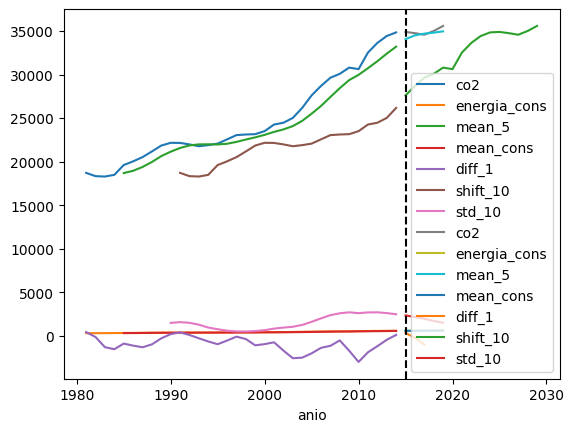

In [126]:
fig, ax = plt.subplots()
train.plot(ax=ax,label='Train')
test.plot(ax=ax,label='Test')
ax.axvline(2015,color='black',ls='--')
plt.show()

<AxesSubplot:xlabel='anio'>

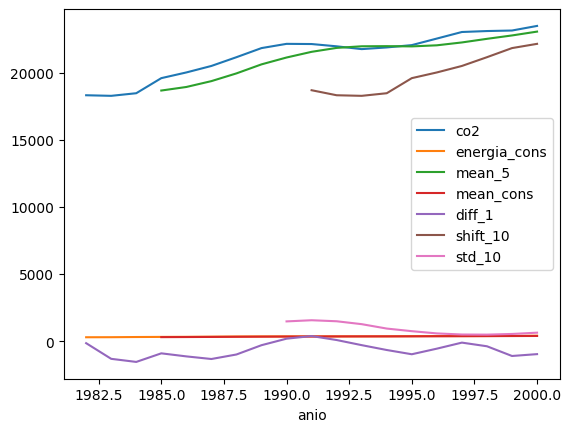

In [127]:
train.loc[(train.index>1981)&(train.index<2001)].plot()

In [128]:
features = [column for column in train.columns if column not in ['pais','co2']]
target = 'co2'

In [129]:
X_train = train[features]
Y_train = train[target]

X_test = test[features]
Y_test = test[target]

In [130]:
reg = xgb.XGBRegressor(n_estimators=12500, learning_rate=0.001)
reg.fit(X_train,Y_train,verbose=1000)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=12500,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [131]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])

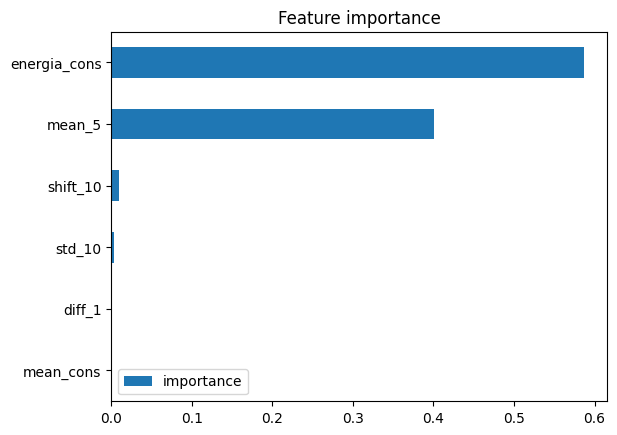

In [132]:
fi.sort_values('importance').plot(kind='barh',title='Feature importance')
plt.show()

In [134]:
test['prediction'] = reg.predict(X_test)
df_fc = df_fc.merge(test[['prediction']],how='left', left_index=True,right_index=True)

Text(0.5, 1.0, 'Test - Prediction')

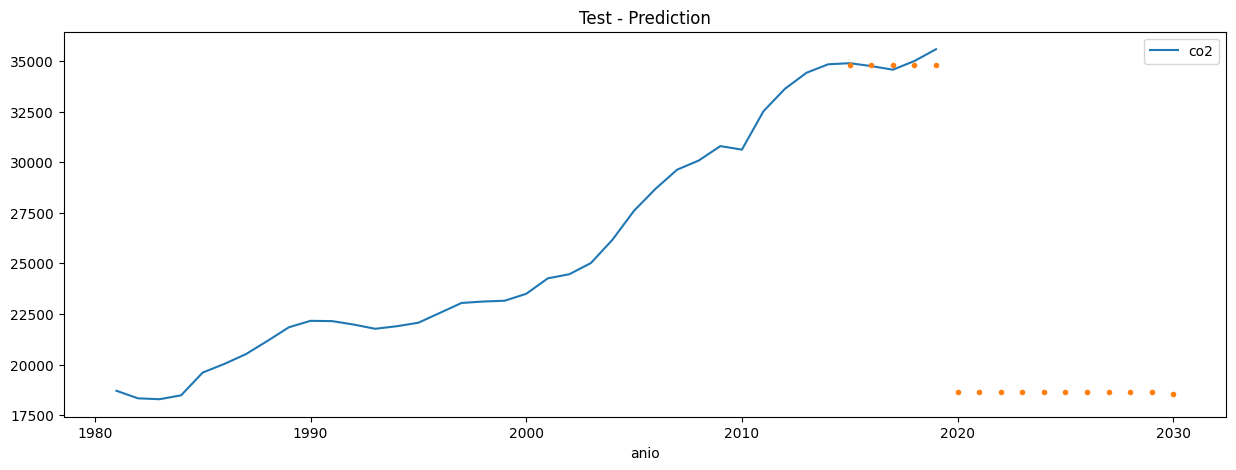

In [135]:
ax = df_fc[['co2']].plot(figsize=(15,5))
df_fc['prediction'].plot(ax=ax,style='.')
ax.set_title('Test - Prediction')

In [394]:
df = df_co2[(df_co2['energia_tipo']=='all_energy_types') & (df_co2['anio']>1980)][['pais','anio','co2','energia_cons']]
df_fc = df[df['pais']=='World']
df_fc = df_fc.reset_index(drop=True)
df_fc['fecha'] = pd.to_datetime(df_fc['anio'],format='%Y')
df_fc = df_fc.copy()
df_fc = df_fc.set_index('fecha').sort_index()

In [199]:
tss = TimeSeriesSplit(n_splits=3, test_size=10, gap=1)

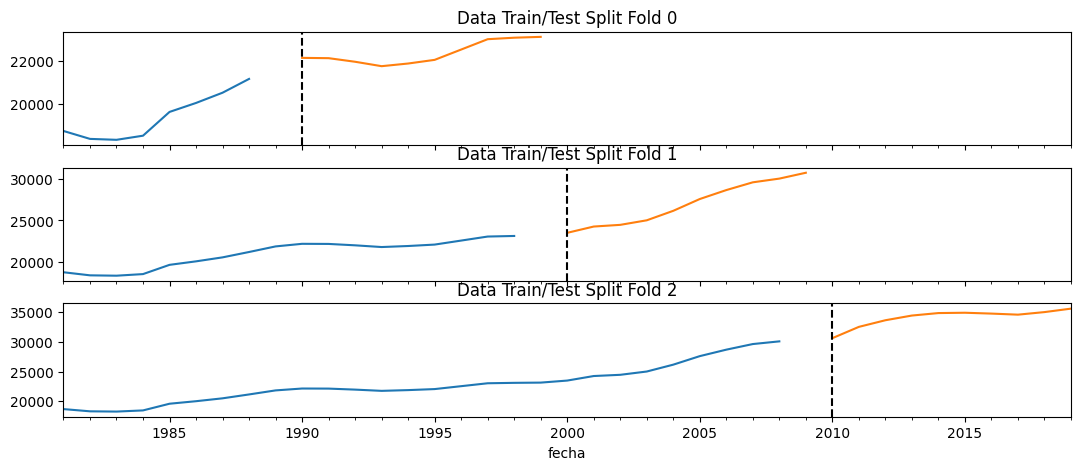

In [206]:
fig, axs = plt.subplots(3,1, figsize=(13,5),sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_fc):
    train = df_fc.iloc[train_idx]
    test = df_fc.iloc[val_idx]
    train['co2'].plot(ax=axs[fold],label='Training Set',title=f'Data Train/Test Split Fold {fold}')
    test['co2'].plot(ax=axs[fold],label='Test Set')
    axs[fold].axvline(test.index.min(),color='black',ls='--')    
    fold +=1
plt.show()

In [231]:
target_map = df_fc['co2'].to_dict()

In [428]:
def addLags(df_fc):
    df_fc =df_fc.copy()    
    # df_fc['lag1'] = (df_fc.index - pd.Timedelta('365 days')).map(target_map)
    df_fc['lag5'] = df_fc['co2'].shift(5)
    df_fc['mean10'] = df_fc['co2'].rolling(10).mean()
    df_fc['lag10'] = df_fc['co2'].shift(11)
    df_fc['cons_lag10'] = df_fc['energia_cons'].shift(11)
    return df_fc

In [429]:
df_fc = addLags(df_fc)

In [443]:
tss = TimeSeriesSplit(n_splits=3, test_size=11,gap=1)
fold=0
preds=[]
scores=[]

for train_idx,val_idx in tss.split(df_fc):
    train = df_fc.iloc[train_idx]
    test = df_fc.iloc[val_idx]

    train = addLags(train)
    test = addLags(test)
    FEATURES = ['energia_cons','lag5','lag10','cons_lag10']
    TARGET = 'co2'
    
    X_train = train[FEATURES]
    Y_train = train[TARGET]
    X_test = test[FEATURES]
    Y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5,booster='gbtree',n_estimators=10000,early_stopping_rounds=50,objective='reg:linear',max_depth=3,learning_rate=0.01)
    reg.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],verbose=1000)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score=np.sqrt(mean_squared_error(Y_test,y_pred))
    scores.append(score)



[14:33:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:18529.06923	validation_1-rmse:21772.42940
[1000]	validation_0-rmse:39.90974	validation_1-rmse:2475.86153
[2000]	validation_0-rmse:0.29351	validation_1-rmse:2401.75819
[2215]	validation_0-rmse:0.16934	validation_1-rmse:2401.44912
[14:33:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20579.55704	validation_1-rmse:25895.99888
[1000]	validation_0-rmse:25.37736	validation_1-rmse:4284.74850
[2000]	validation_0-rmse:1.04405	validation_1-rmse:4240.74622
[2376]	validation_0-rmse:0.35754	validation_1-rmse:4240.50946
[14:34:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecat

In [431]:
print(f"The mean score across folds: {np.mean(scores):0.4f}")

The mean score across folds: 3702.3873


# Predict into the future
We need to create a "skeleton" dataframe with dates for which we want to predict our target.

In [432]:
df = df_co2[(df_co2['energia_tipo']=='all_energy_types') & (df_co2['anio']>1980)][['pais','anio','co2','energia_cons']]
df_fc = df[df['pais']=='World']
df_fc = df_fc.reset_index(drop=True)
df_fc['fecha'] = pd.to_datetime(df_fc['anio'],format='%Y')
df_fc = df_fc.copy()
df_fc = df_fc.set_index('fecha').sort_index()

In [433]:
df_fc = addLags(df_fc)
FEATURES = ['energia_cons','lag10','cons_lag10','mean10']
TARGET = 'co2'

X_all = df_fc[FEATURES]
Y_all = df_fc[TARGET]
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree', 
                       n_estimators=3100,early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=5,learning_rate=0.01)
reg.fit(X_all,Y_all,eval_set=[(X_all,Y_all)],verbose=100)

[13:51:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:26308.75430
[100]	validation_0-rmse:10330.76913
[200]	validation_0-rmse:4119.64948
[300]	validation_0-rmse:1666.80437
[400]	validation_0-rmse:693.04570
[500]	validation_0-rmse:311.09138
[600]	validation_0-rmse:158.45129
[700]	validation_0-rmse:89.73950
[800]	validation_0-rmse:53.64606
[900]	validation_0-rmse:33.14961
[1000]	validation_0-rmse:21.03571
[1100]	validation_0-rmse:13.87951
[1200]	validation_0-rmse:9.57569
[1300]	validation_0-rmse:6.90767
[1400]	validation_0-rmse:4.93454
[1500]	validation_0-rmse:3.71182
[1600]	validation_0-rmse:2.87379
[1700]	validation_0-rmse:2.27831
[1800]	validation_0-rmse:1.75914
[1900]	validation_0-rmse:1.42770
[2000]	validation_0-rmse:1.12807
[2100]	validation_0-rmse:0.91648
[2200]	validation_0-rmse:0.74994
[2300]	validation_0-rmse:0.61413
[2400]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=3100,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [438]:
future = pd.date_range(start='2020-01-01', end='2030-01-01', freq='12MS',inclusive='both')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_fc['isFuture'] = False
df_andFuture = pd.concat([df_fc,future_df])

In [439]:
df_andFuture = addLags(df_andFuture)

In [440]:
future_features = df_andFuture[df_andFuture['isFuture']==True].copy()
future_features['pred'] = reg.predict(future_features[FEATURES])

<AxesSubplot:title={'center':'Future pred'}>

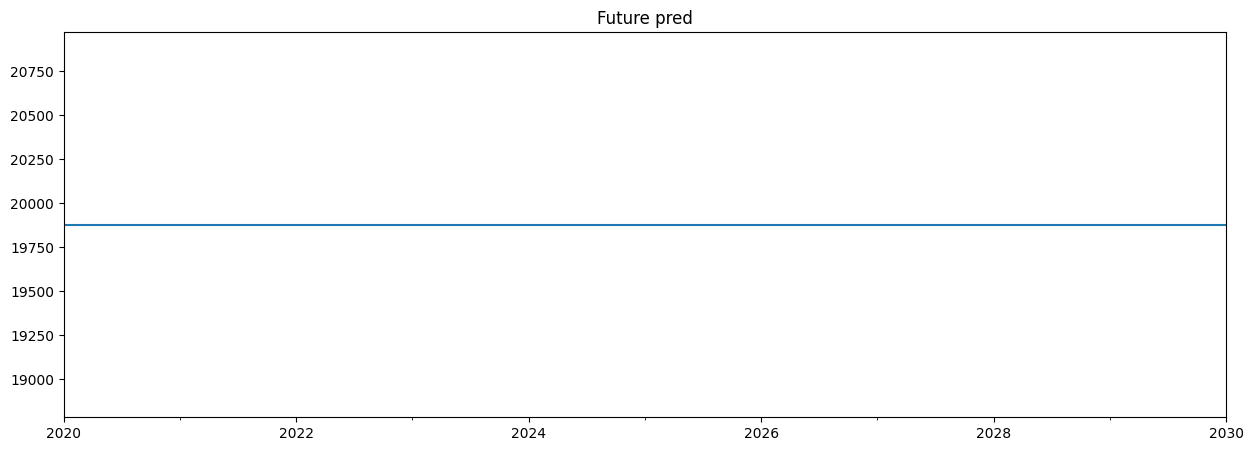

In [441]:
future_features['pred'].plot(figsize=(15,5),title='Future pred')

In [508]:
top = ['United States','China','Canada','Japan']

In [514]:
df_co2[(df_co2['pais'].isin(top))&(df_co2['energia_tipo']=='all_energy_types')].groupby('anio').sum().reset_index()

,anio,energia_cons,energia_produccion,pbi,poblacion,energia_intensidad_per_capita,energia_intensidad_by_pbi,co2
0,1980,122.49,99.18,11101.88,1371354.15,886.30,58.67,4946.63
1,1981,120.23,98.59,11452.66,1389389.90,862.88,55.70,7647.31
2,1982,117.30,99.45,11455.47,1407044.25,822.31,54.04,7471.47
3,1983,118.28,98.80,11985.01,1424847.42,812.38,52.01,7217.46
4,1984,125.20,106.64,12833.87,1443418.67,850.87,50.44,7327.41
5,1985,126.65,108.86,13495.75,1463541.12,858.06,48.08,7928.87
6,1986,127.81,109.01,14010.84,1486101.27,857.32,46.35,8019.47
7,1987,132.31,111.29,14642.96,1510507.38,875.09,44.98,8088.89
8,1988,139.22,114.79,15448.62,1535253.78,907.64,44.22,8393.15
9,1989,142.12,116.90,16053.85,1559014.98,913.59,43.25,8869.02


In [543]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [536]:
df_co2.head()
df = pd.DataFrame()
df[['anio','prod','cons','co2']] = df_co2[(df_co2['pais'].isin(top))&(df_co2['energia_tipo']=='all_energy_types')].groupby('anio').sum().reset_index()[['anio','energia_produccion','energia_cons','co2']].copy()
df = df[df['anio']>1980].copy()

In [537]:
df['fecha'] = pd.to_datetime(df['anio'],format='%Y')
df = df.set_index('fecha')
df = df.asfreq(freq='yS')

In [538]:
print(f'Número de filas con missing values: {df.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


Fechas train : 1981-01-01 00:00:00 --- 2008-01-01 00:00:00  (n=28)
Fechas test  : 2009-01-01 00:00:00 --- 2019-01-01 00:00:00  (n=11)


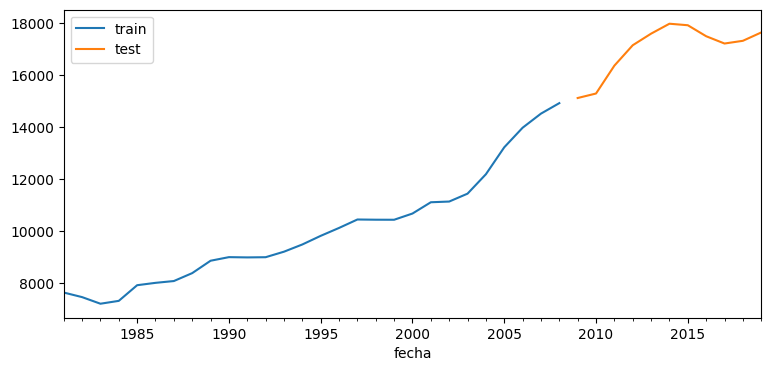

In [539]:
steps = 11
datos_train = df[:-steps]
datos_test  = df[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['co2'].plot(ax=ax, label='train')
datos_test['co2'].plot(ax=ax, label='test')
ax.legend();

In [562]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 3
             )

forecaster.fit(y=datos_train['co2'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Window size: 3 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1981-01-01 00:00:00'), Timestamp('2008-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: AS-JAN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-05 15:30:52 
Last fit date: 2022-09-05 15:30:53 
Skforecast version: 0.4.3 

In [563]:
steps = 11
predicciones = forecaster.predict(steps=steps)
predicciones.tail(5)

2015-01-01    14650.1522
2016-01-01    14650.1522
2017-01-01    14650.1522
2018-01-01    14650.1522
2019-01-01    14650.1522
Freq: AS-JAN, Name: pred, dtype: float64

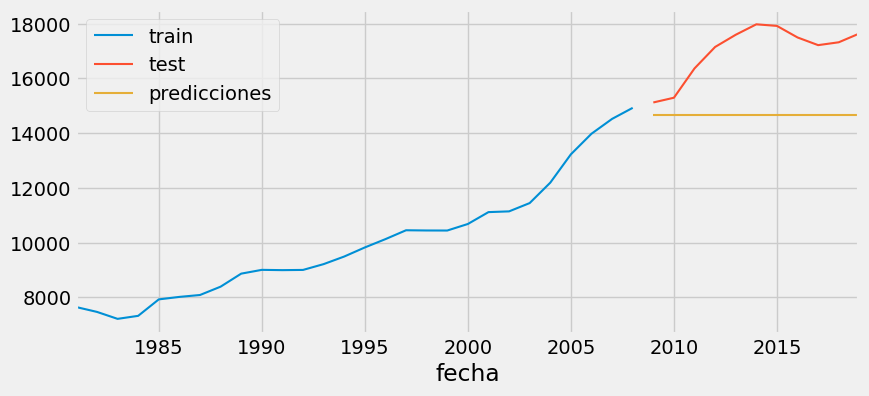

In [564]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['co2'].plot(ax=ax, label='train')
datos_test['co2'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [565]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['co2'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 6451239.242169267


In [15]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [16]:
data = pd.read_csv(r"C:\Users\ferch\Downloads\co2_trend_gl.csv",sep=',',skiprows=41)
dc = pd.DataFrame(data)
datos = dc.copy()

In [17]:
datos['fecha'] = pd.to_datetime(dc[['day','month','year']])
datos = datos.set_index('fecha')

In [21]:
datos = datos.rename(columns={'smoothed':'y','trend':'exog_1'})

In [22]:
datos

,year,month,day,y,trend
fecha,,,,,
2012-01-01,2012,1,1,392.93,391.47
2012-01-02,2012,1,2,392.96,391.48
2012-01-03,2012,1,3,392.99,391.48
2012-01-04,2012,1,4,393.02,391.49
2012-01-05,2012,1,5,393.04,391.50
...,...,...,...,...,...
2022-08-31,2022,8,31,413.82,417.62
2022-09-01,2022,9,1,413.83,417.63
2022-09-02,2022,9,2,413.85,417.63
